In [31]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#import NEATM
from NEATM2 import *
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9             #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
Hv = 22.1
G = 0.15
Ndd = 15
lamdai = [4.6,12,22]

### load epoch & cal epoch , define "x"

In [32]:
name = '2014FD7'
#df = pd.read_table(f'ws.dat.{name}')
ast = np.loadtxt(f'ws.dat.{name}',skiprows=1,usecols=(5,6,7))
ear = np.loadtxt(f'ws.dat.{name}',skiprows=1,usecols=(8,9,10))
#ast-sun
d_N = np.sqrt(ast[:,0]**2+ast[:,1]**2+ast[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((ast[:,0]-ear[:,0])**2+(ast[:,1]-ear[:,1])**2+(ast[:,2]-ear[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(ear[:,0]**2+ear[:,1]**2+ear[:,2]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
x = (delta_N,d_N,alpha_N)

### load obs data , define "y"

In [33]:
time = np.loadtxt(f'mba.jd.{name}')
mjdtime = time-2400000.5
obsdat = np.loadtxt(f'obsNEW.txt.{name}')
n4 = len(obsdat)//4
w1 = obsdat[:n4]
w2 = obsdat[n4:2*n4]
w3 = obsdat[2*n4:n4*3]
w4 = obsdat[n4*3:]
'''plt.subplot(2,1,1)
plt.plot(mjdtime[:n3//2+5],w2[:n3//2+5],'bo',label='w2')
plt.plot(mjdtime[:n3//2+5],w3[:n3//2+5],'yo',label='w3')
plt.plot(mjdtime[:n3//2+5],w4[:n3//2+5],'ro',label='w4')
plt.subplot(2,1,2)
plt.plot(mjdtime[n3//2+5:],w2[n3//2+5:],'bo',label='w2')
plt.plot(mjdtime[n3//2+5:],w3[n3//2+5:],'yo',label='w3')
plt.plot(mjdtime[n3//2+5:],w4[n3//2+5:],'ro',label='w4')
plt.legend()'''
y = obsdat

## model

In [34]:
def Model_neatm_Ref_jhx(theta,x,lamda):
    '''
    theta = (eta,D,wf)
    x = (astp,obsp)
    x = (3.4x;4.6x;12x;22x)
    '''
    eta,D,wf ,logf = theta
    astp,obsp = x
    lamda2,lamda3,lamda4 = lamda
    #print('k',astp)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    flux = np.zeros(n4*4)
    for i in range(n4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A,Hv)
        flux[i] = 1.3917*fluxi + 1.0049*(wf*frLambi + frLommi)
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(n4,2*n4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A,Hv)
        flux[i] = 1.1124*fluxi + 1.0193*(wf*frLambi + frLommi)
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(2*n4,n4*3):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda3,eta,A,Hv)
        flux[i] = 0.8791*fluxi 
        #print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(n4*3,n4*4):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda4,eta,A,Hv)
        flux[i] = 0.9865*fluxi     
       # print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    return flux    

### cal flux with ref

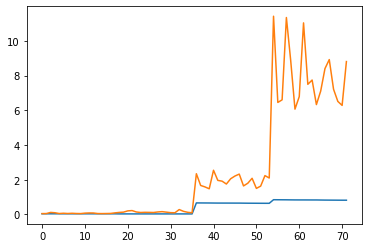

In [35]:
xast = np.vstack((ast,ast,ast,ast))
xear  =  np.vstack((ear,ear,ear,ear))
xt = (xast,xear)
flux = Model_neatm_Ref_jhx((1.5,115,0.5,0.5),xt,(4.6,12,22))
plt.plot(flux)
plt.plot(y)

## MCMC

In [36]:
#initial
eta_gs = 1.2
D_gs = 150
eta_gss = [0.5,4]
D_gss = [1,500]
wf_gs = 0.2
wf_gss = [0,0.5]
logf_gs = 0.4
logf_gss = [-10,1]

In [37]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D,wf,logf = theta
    model = Model_neatm_Ref_jhx(theta,x,lamdai)
    #model = eta*x[0]*100 + D
    sigma2 = yerr**2 + model**2 * np.exp(2 * logf)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D,wf,logf = theta
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1] and wf_gss[0] < wf < wf_gss[1] and  -10.0 < logf < 1.0:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [38]:
#initial para guesses
eta = eta_gs
D = D_gs
wf = wf_gs
logf = logf_gs
theta = [eta, D,wf,logf]

In [39]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 10
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xt, y, y*0.1))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 5000#, progress=True);

/home/astrohhq/learngit/newwisedata/test/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
100%|██████████| 5000/5000 [1:12:12<00:00,  1.15it/s]


In [40]:
frac = sampler.acceptance_fraction
frac

array([0.5506, 0.5348, 0.5508, 0.5556, 0.5442, 0.5356, 0.5448, 0.5282,
       0.55  , 0.5586])

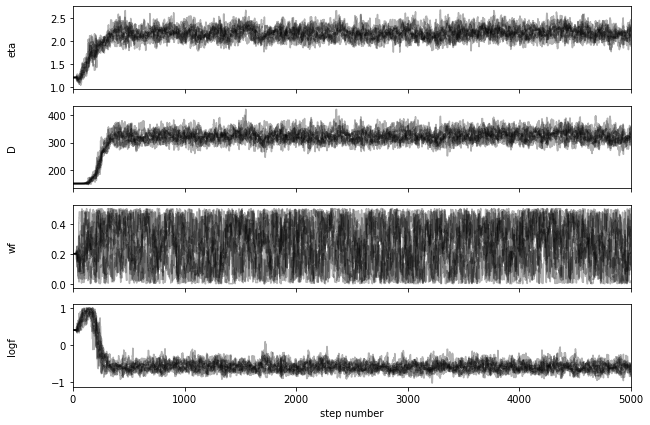

In [41]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D", "wf","logf"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

(2930, 4)


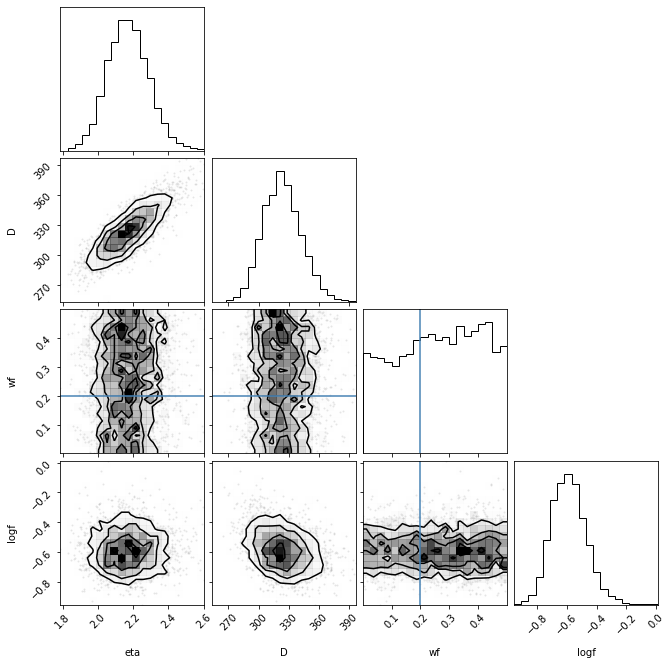

In [48]:
#--------------------------
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, D_gs,wf_gs,logf_gs]
);

In [49]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  150 pv= 0.024507032573704738


/home/astrohhq/learngit/newwisedata/test/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


[1.8, 201, 0.257, 1]

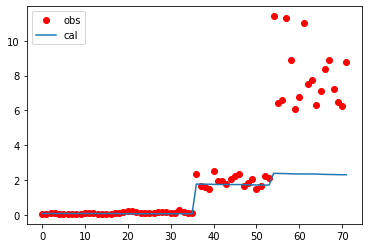

In [50]:
eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
wf_low,wf_fit,wf_high = np.percentile(flat_samples[:, 2], [16, 50, 84])
plt.plot(y,'ro',label='obs')
test = [1.8, 201, 0.257,1]
plt.plot(Model_neatm_Ref_jhx(test,xt,lamdai),label='cal')
plt.legend()
test

In [51]:
def loss(obs,cal,err):
    l = len(obs)
    return sum(((obs-cal)/err)**2)/l
print('LossFunction = ',loss(y,Model_neatm_Ref_jhx(test,xt,lamdai),y*0.1))


LossFunction =  24.284963788071448


/home/astrohhq/learngit/newwisedata/test/NEATM2.py:188: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
